                 Model  Accuracy  Precision    Recall  F1 Score
0  Logistic Regression  0.972192   0.050334  0.873684  0.095183
1        Random Forest  0.999436   0.909091  0.736842  0.813953
2              XGBoost  0.999418   0.844444  0.800000  0.821622
                 Model  Accuracy  Precision    Recall  F1 Score  F2 Score
0  Logistic Regression  0.972192   0.050334  0.873684  0.095183  0.204534
1        Random Forest  0.999436   0.909091  0.736842  0.813953  0.765864
2              XGBoost  0.999418   0.844444  0.800000  0.821622  0.808511
                 Model  Accuracy  Precision    Recall  F1 Score  F2 Score  \
0  Logistic Regression  0.972192   0.050334  0.873684  0.095183  0.204534   
1        Random Forest  0.999436   0.909091  0.736842  0.813953  0.765864   
2              XGBoost  0.999418   0.844444  0.800000  0.821622  0.808511   

   Precision-Recall AUC  
0                   NaN  
1              0.814775  
2                   NaN  
                 Model  Accuracy  P

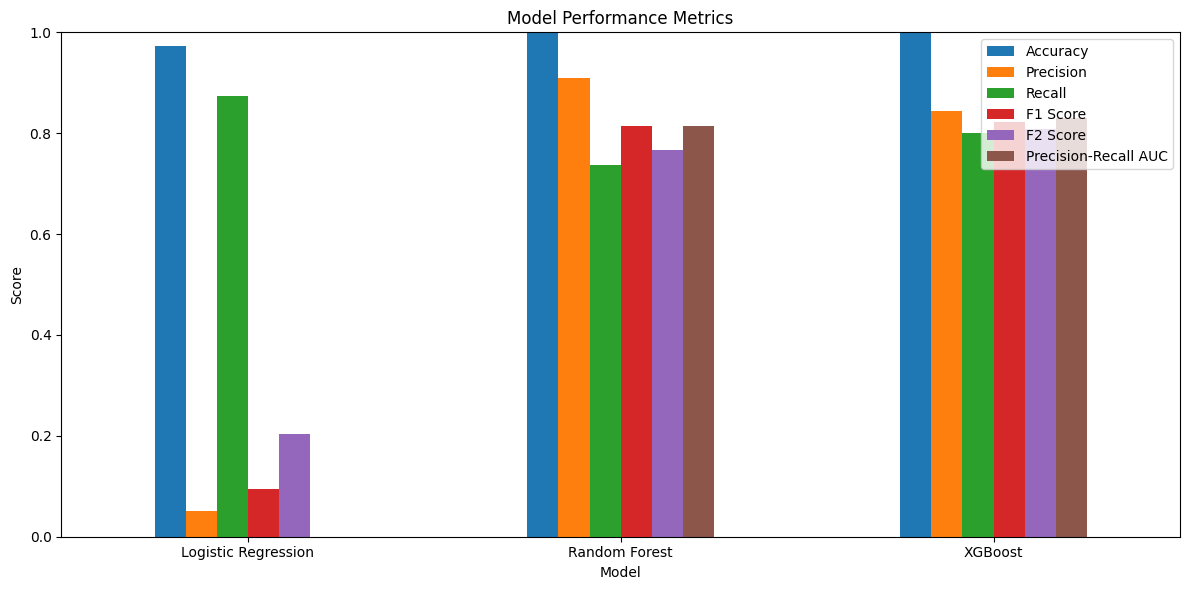

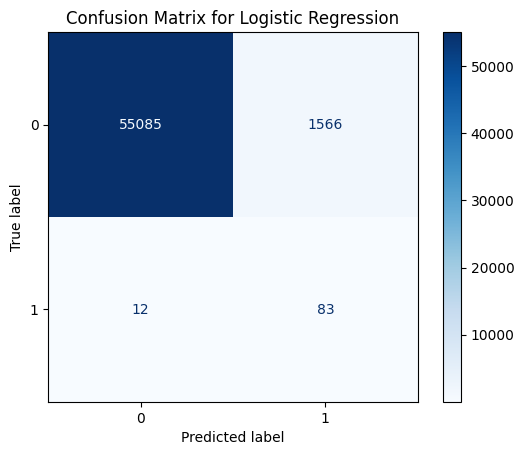

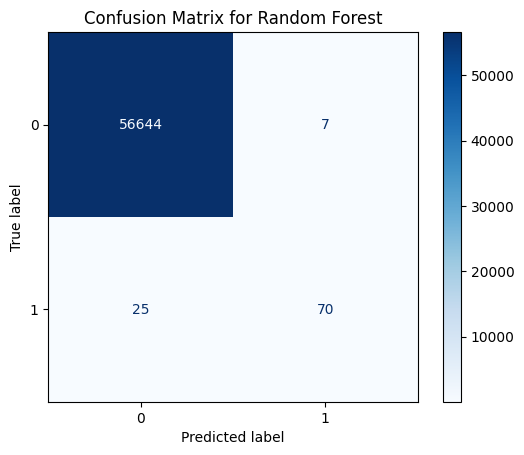

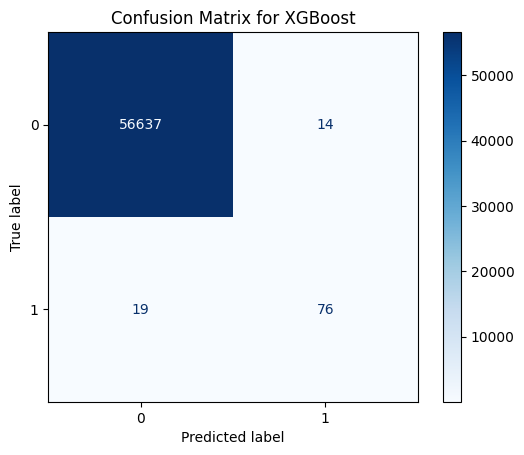

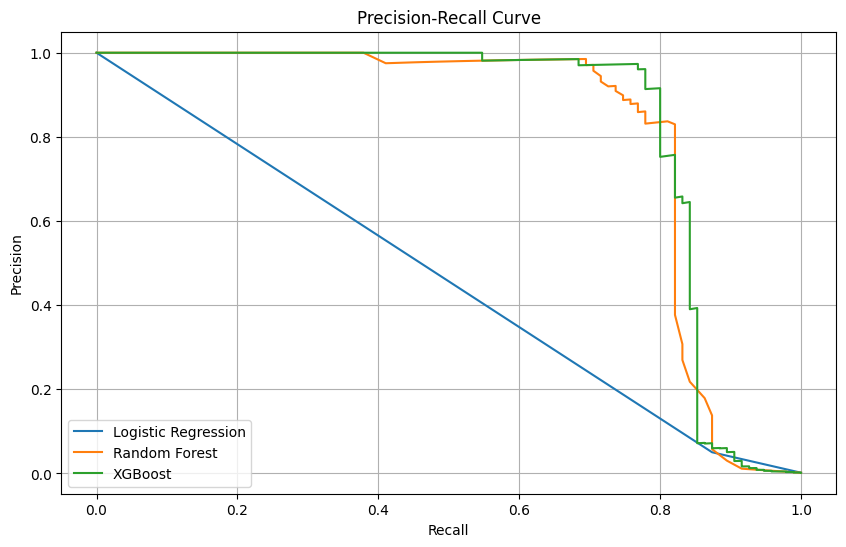

       Feature  Importance
13         V14    0.613481
3           V4    0.055392
30  time_delta    0.042754
7           V8    0.023396
11         V12    0.021964
9          V10    0.019107
6           V7    0.017025
16         V17    0.016899
10         V11    0.013808
12         V13    0.013098


In [3]:
# importing necessary libraries
import pandas as pd
import numpy as np
import joblib as jb
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix, ConfusionMatrixDisplay,accuracy_score, precision_score, recall_score, f1_score, fbeta_score
import matplotlib.pyplot as plt
import xgboost as xgb
# Load predictions
predictions_df = pd.read_csv('../data/processed/model_predictions.csv')
y_test = predictions_df['y_test'].values
y_pred_logistic = predictions_df['y_pred_logistic'].values
y_pred_rf = predictions_df['y_pred_rf'].values
y_pred_xgb = predictions_df['y_pred_xgb'].values
# Load models and test data
rf_model = jb.load('../models/random_forest.pkl')
X_test = pd.read_csv('../data/processed/X_test.csv')
y_test = pd.read_csv('../data/processed/y_test.csv').values.ravel()
#Probability scores for fraud class
y_proba=rf_model.predict_proba(X_test)[:, 1] # Assuming the positive class (fraud) is labeled as 1

#Dynamicly calculating metrtics 


metrics_df = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "XGBoost"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_logistic),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_xgb)
    ],
    "Precision": [
        precision_score(y_test, y_pred_logistic),
        precision_score(y_test, y_pred_rf),
        precision_score(y_test, y_pred_xgb)
    ],
    "Recall": [
        recall_score(y_test, y_pred_logistic),
        recall_score(y_test, y_pred_rf),
        recall_score(y_test, y_pred_xgb)
    ],
    "F1 Score": [
        f1_score(y_test, y_pred_logistic),
        f1_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_xgb)
    ]
})
print(metrics_df)
# Adding F2 score to the metrics dataframe
metrics_df["F2 Score"] = [
    fbeta_score(y_test, y_pred_logistic, beta=2),
    fbeta_score(y_test, y_pred_rf, beta=2),
    fbeta_score(y_test, y_pred_xgb, beta=2)
]
print(metrics_df)
#Adding presicion-recall AUC for random forest model
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_proba)
auc_rf = auc(recall_rf, precision_rf)
metrics_df["Precision-Recall AUC"] = [None, auc_rf, None] # Only for Random Forest
print(metrics_df)
#Adding precision-recall AUC for XGBoost model
y_proba_xgb = jb.load('../models/xgboost.pkl').predict_proba(X_test)[:, 1]
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_proba_xgb)
auc_xgb = auc(recall_xgb, precision_xgb)
metrics_df["Precision-Recall AUC"] = [None, auc_rf, auc_xgb] # Update for XGBoost
print(metrics_df)
#Visualization of the metrics including the new F2 score and Precision-Recall AUC
metrics_df.set_index("Model", inplace=True)
metrics_df[["Accuracy", "Precision", "Recall", "F1 Score", "F2 Score", "Precision-Recall AUC"]].plot(kind="bar", figsize=(12, 6))
plt.title("Model Performance Metrics")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()
#Confusion matrix visualization for each model, not only numbers but also the visual representation of the confusion matrix for each model to better understand their performance in terms of true positives, true negatives, false positives, and false negatives.
models = {
    "Logistic Regression": y_pred_logistic,
    "Random Forest": y_pred_rf,
    "XGBoost": y_pred_xgb
}
for model_name, y_pred in models.items():
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()
# Precision-Recall curve for all models
plt.figure(figsize=(10, 6))
# Logistic Regression
precision_logistic, recall_logistic, _ = precision_recall_curve(y_test, y_pred_logistic)
plt.plot(recall_logistic, precision_logistic, label="Logistic Regression")
# Random Forest
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_proba)
plt.plot(recall_rf, precision_rf, label="Random Forest")
# XGBoost
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_proba_xgb)
plt.plot(recall_xgb, precision_xgb, label="XGBoost")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()
#Future importance for XGBoost model
xgb_model = jb.load('../models/xgboost.pkl')
feature_importance = pd.DataFrame({
    "Feature": X_test.columns,
    "Importance": xgb_model.feature_importances_
}).sort_values(by="Importance", ascending=False)
print(feature_importance.head(10))

